In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append("../../src")
from evaluate_gaze import EvaluateGaze

In [3]:
user_id = 15
df = pd.read_csv(f"../data/eval_data/gaze_user{user_id}_eval_9.csv")

df.head()

,flag,xl,yl,zl,xr,yr,zr,xc,yc,zc,...,ray_x,ray_y,ray_z,eye_x,eye_y,eye_z,time,frame,u,v
0,25.0,0.211403,0.153430,1.000100,0.093358,0.080965,1.000089,0.152380,0.117197,1.000094,...,0.147517,0.112935,0.982591,-0.000787,-0.000064,-0.020131,73.98889,4622.0,0.175,0.104
1,25.0,0.211423,0.153372,1.000036,0.093410,0.080392,1.000038,0.152417,0.116882,1.000037,...,0.147564,0.112641,0.982617,-0.000787,-0.000064,-0.020129,74.00000,4623.0,0.175,0.104
2,25.0,0.211438,0.153158,1.000241,0.093240,0.080451,1.000211,0.152338,0.116804,1.000226,...,0.147466,0.112548,0.982643,-0.000786,-0.000064,-0.020124,74.02222,4624.0,0.175,0.104
3,25.0,0.211537,0.155662,1.000142,0.093546,0.080459,1.000111,0.152541,0.118060,1.000126,...,0.147651,0.113751,0.982476,-0.000786,-0.000064,-0.020122,74.03333,4625.0,0.175,0.104
4,25.0,0.211480,0.155752,1.000091,0.093531,0.082329,1.000090,0.152506,0.119040,1.000090,...,0.147606,0.114686,0.982374,-0.000786,-0.000063,-0.020121,74.05556,4626.0,0.175,0.104


In [4]:
# gaze direction
ray_x = df["ray_x"].values
ray_y = df["ray_y"].values
ray_z = df["ray_z"].values

# gaze direction at z=1
xe = ray_x[:] / ray_z[:] * 1.0
ye = ray_y[:] / ray_z[:] * 1.0

# marker position on a calibration plane at 1m away (HMD coordinates)
p = df["u"].values
q = df["v"].values

# origin (HMD coordinates)
eye_x = df["eye_x"].values
eye_y = df["eye_y"].values
eye_z = df["eye_z"].values

# gaze position on a calibration plane at 1m away (HMD coordinates)
ones = np.ones_like(eye_z)
t = (ones - eye_z) / ray_z
xh = eye_x + t * ray_x
yh = eye_y + t * ray_y

## Evaluate raw gaze direction

In [5]:
param_raw = [0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
param_raw

[0.0, 1.0, 0.0, 0.0, 0.0, 1.0]

In [6]:
rmse_raw = EvaluateGaze.err_rmse_reg(param_raw, xe, ye, eye_x, eye_y, eye_z, p, q)
print(f"RMSE: {rmse_raw}")

angle_err = np.rad2deg(np.arctan(rmse_raw))
print(f"angle_err: {angle_err}")

RMSE: 0.04370755924393763
angle_err: 2.5026658320317385


## Evaluate visual axis

In [7]:
pramm_vis = pd.read_csv(f"../param/baseline_param.csv").values[user_id-1]
pramm_vis

array([ 0.01111168,  1.09547827,  0.00541734, -0.02590663,  0.00639171,
        1.15887257])

In [8]:
# calibrate gaze direction
calib_xe, calib_ye = EvaluateGaze.calibrate_reg(pramm_vis, xe, ye)

# convert gaze position on calibration plane at 1m away (HMD coordinates)
ones = np.ones_like(calib_xe)
t = (ones - eye_z) / 1.0
calib_xh = eye_x + t * calib_xe
calib_yh = eye_y + t * calib_ye

In [9]:
rmse_vis = EvaluateGaze.err_rmse_reg(pramm_vis, xe, ye, eye_x, eye_y, eye_z, p, q)
print(f"RMSE: {rmse_vis}")

angle_err = np.rad2deg(np.arctan(rmse_vis))
print(f"angle_err: {angle_err}")

RMSE: 0.01249627112024992
angle_err: 0.7159463297659151


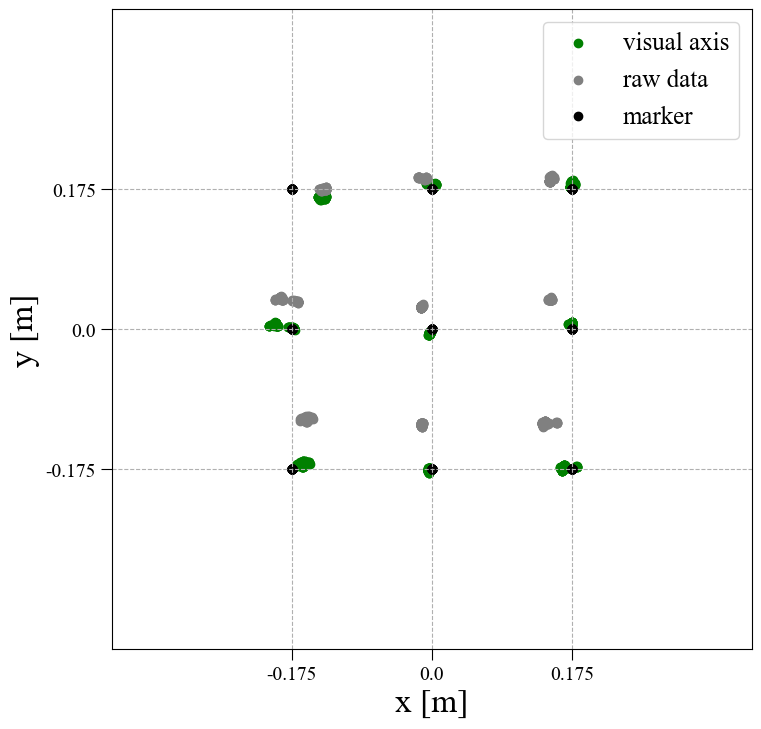

In [10]:
label_xy = [-0.7/4, 0.0, 0.7/4]

# キャリブレーション後
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

fig = plt.figure(figsize=(8, 8))
fig.patch.set_facecolor("white")

plt.scatter(calib_xh, calib_yh, c="green", label="visual axis")
plt.scatter(xh, yh, c="gray", label="raw data")
plt.scatter(p, q, c="black", label="marker")

plt.xlabel("x [m]",  size=24)
plt.ylabel("y [m]",  size=24)

plt.xlim(-0.4, 0.4)
plt.ylim(-0.4-0.071, 0.4-0.071)
plt.xticks([-0.175, 0.0, 0.175], label_xy, fontsize=14)
plt.yticks([-0.175-0.071, -0.071, 0.175-0.071], label_xy, fontsize=14)

plt.grid(which="major", axis="both", linestyle='--')
plt.tick_params(length=8)
plt.legend(fontsize=18, loc="upper right")
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.1, top=0.9)
plt.show()

## Evaluate optical axis

In [11]:
param_opt = EvaluateGaze.get_rotation([-1.021, -3.306]).flatten()
param_opt

array([ 0.99984123, -0.00102759, -0.01778921,  0.        ,  0.99833578,
       -0.05766857,  0.01781887,  0.05765942,  0.99817728])

In [12]:
r = np.sqrt(calib_xe * calib_xe + calib_ye * calib_ye + 1)
ray = np.stack([calib_xe/r, calib_ye/r, 1/r], axis=1)
ray.shape

(566, 3)

In [13]:
# calibrate gaze direction
calib_ray = EvaluateGaze.calibrate_3d(param_opt, ray)

# calculate gaze direction at z=1
calib_xe2 = calib_ray[:, 0] / calib_ray[:, 2] * 1.0
calib_ye2 = calib_ray[:, 1] / calib_ray[:, 2] * 1.0

# convert gaze position on calibration plane at 1m away (HMD coordinates)
ones = np.ones_like(calib_xe2)
t = (ones - eye_z) / 1.0
calib_xh2 = eye_x + t * calib_xe2
calib_yh2 = eye_y + t * calib_ye2

In [14]:
rmse_opt = EvaluateGaze.err_rmse_3d(param_opt, ray, eye_x, eye_y, eye_z, p, q)
print(f"RMSE: {rmse_opt}")

angle_err = np.rad2deg(np.arctan(rmse_opt))
print(f"angle_err: {angle_err}")

RMSE: 0.06273761488668066
angle_err: 3.5898955302409608


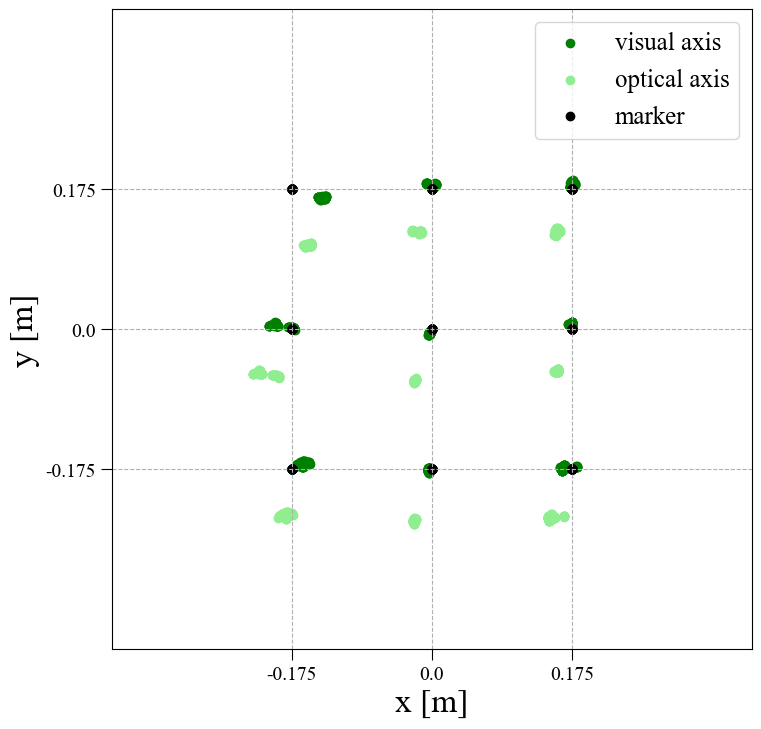

In [15]:
label_xy = [-0.7/4, 0.0, 0.7/4]

# キャリブレーション後
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

fig = plt.figure(figsize=(8, 8))
fig.patch.set_facecolor("white")

plt.scatter(calib_xh, calib_yh, c="green", label="visual axis")
plt.scatter(calib_xh2, calib_yh2, c="lightgreen", label="optical axis")
plt.scatter(p, q, c="black", label="marker")

plt.xlabel("x [m]",  size=24)
plt.ylabel("y [m]",  size=24)

plt.xlim(-0.4, 0.4)
plt.ylim(-0.4-0.071, 0.4-0.071)
plt.xticks([-0.175, 0.0, 0.175], label_xy, fontsize=14)
plt.yticks([-0.175-0.071, -0.071, 0.175-0.071], label_xy, fontsize=14)

plt.grid(which="major", axis="both", linestyle='--')
plt.tick_params(length=8)
plt.legend(fontsize=18, loc="upper right")
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.1, top=0.9)
plt.show()